# Bike Sharing Assignment

#### Importing all important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

#### Importing the data

In [2]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Step 1: Reading, Understanding, and Visualising the Data

Taking care of null/missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


So, no data to drop or impute

Adding a derived column of day in the date, and dropping the dteday columns.

In [4]:
df[ 'dteday' ] = pd.to_datetime( df[ 'dteday' ], format="%d-%m-%Y" )
df[ 'day' ] = df[ 'dteday' ].dt.strftime('%d')
df.drop(columns=['dteday'], inplace=True)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,01
1,2,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,02
2,3,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,03
3,4,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,04
4,5,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,05


Mapping Categorical Values as per the Description (from Readme.txt)

In [5]:
df['season'] = df['season'].map({
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
})
df['weekday'] = df['weekday'].map({
    0: 'sun',
    1: 'mon',
    2: 'tue',
    3: 'wed',
    4: 'thu',
    5: 'fri',
    6: 'sat'
})
df['weathersit'] = df['weathersit'].map({
    1: 'best_weather',
    2: 'avg_weather',
    3: 'bad_weather',
    4: 'worst_weather'
})

df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,spring,0,1,0,sat,0,avg_weather,14.110847,18.18125,80.5833,10.749882,331,654,985,01
1,2,spring,0,1,0,sun,0,avg_weather,14.902598,17.68695,69.6087,16.652113,131,670,801,02
2,3,spring,0,1,0,mon,1,best_weather,8.050924,9.47025,43.7273,16.636703,120,1229,1349,03
3,4,spring,0,1,0,tue,1,best_weather,8.200000,10.60610,59.0435,10.739832,108,1454,1562,04
4,5,spring,0,1,0,wed,1,best_weather,9.305237,11.46350,43.6957,12.522300,82,1518,1600,05


Checking the number of unique values in each column to figure out categorical and numeric columns

In [6]:
df.nunique()

instant       730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
casual        605
registered    678
cnt           695
day            31
dtype: int64

So,
- X numeric columns: temp, atemp, hum, windspeed
- X categorical columns: season, yr, mnth, holiday, weekday, workingday, weathersit
- X date columns: dteday
- Y(target) variable: cnt
- Y non useful variable: casual, registered
- index columns: instant

#### Separating the Categorical and Numercal X and y Columns

In [7]:
X_num_cols = ['temp', 'atemp', 'hum', 'windspeed']
X_cat_cols = ['season', 'yr', 'day', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
other_cols = [ 'instant', 'casual', 'registered' ]

y_col = 'cnt'

Dropping other columns other than X and y

In [8]:
df.drop(columns=other_cols, inplace=True)

#### Analysis on X Numeric Columns

In [9]:
df[ X_num_cols ].describe()

,temp,atemp,hum,windspeed
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620
std,7.506729,8.150308,14.237589,5.195841
min,2.424346,3.953480,0.000000,1.500244
25%,13.811885,16.889713,52.000000,9.041650
50%,20.465826,24.368225,62.625000,12.125325
75%,26.880615,30.445775,72.989575,15.625589
max,35.328347,42.044800,97.250000,34.000021


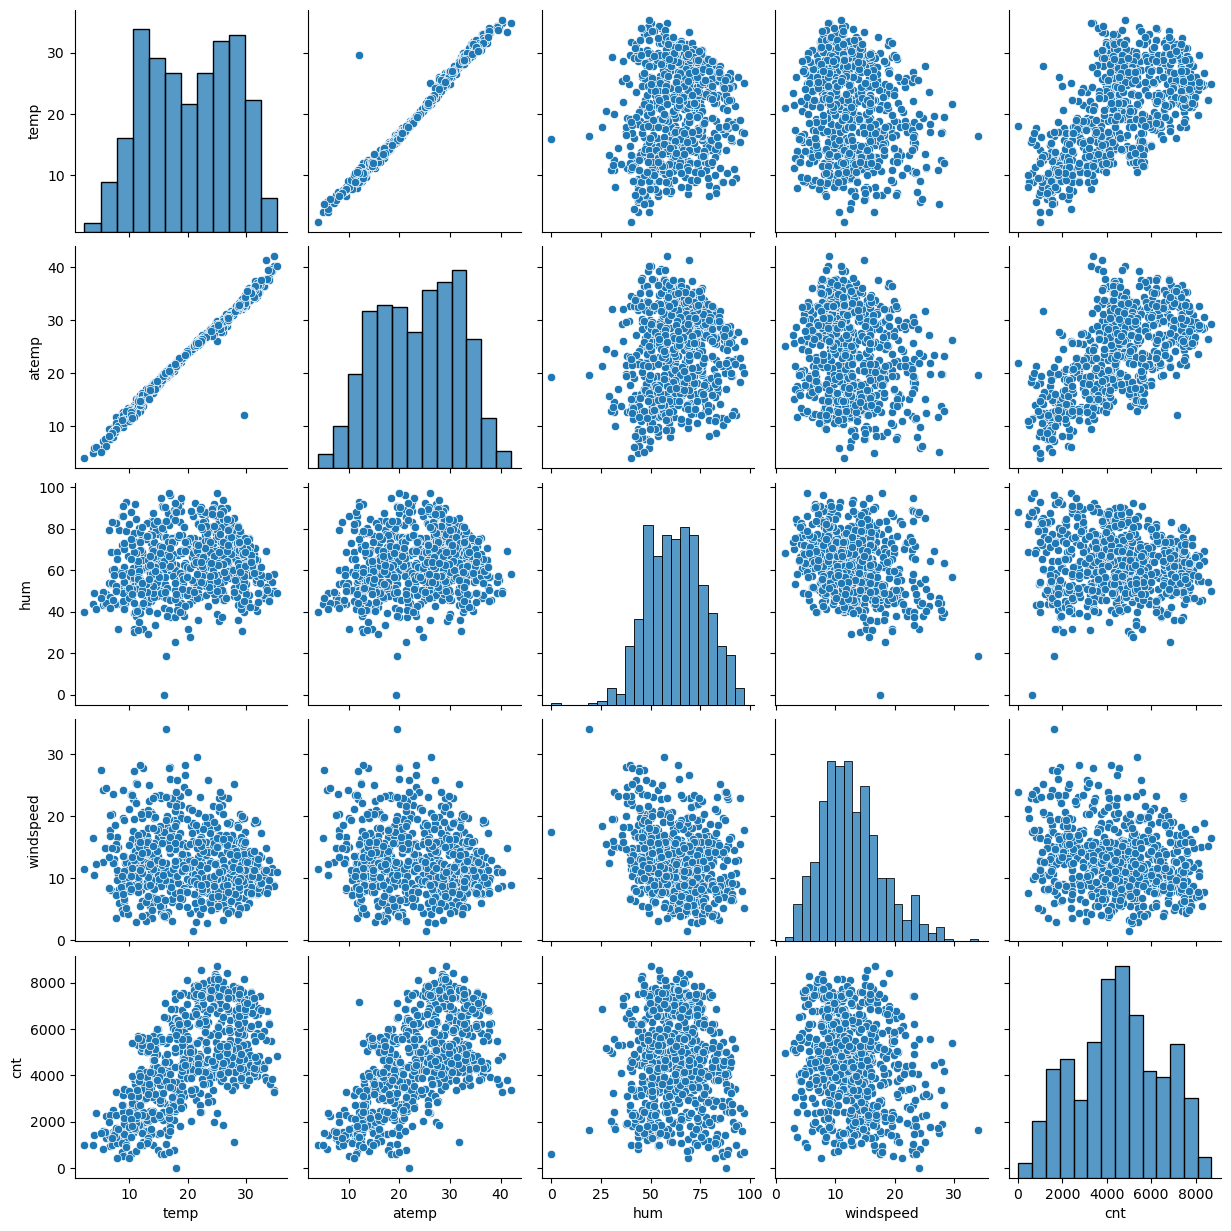

In [10]:
sns.pairplot(df[ X_num_cols + [y_col] ])
plt.show()

2 major takeaways:
- temp and atemp seems to be highly correlated.
- There seems to be a small linear relationship bw target variable cnt, and the variables temp and atemp.

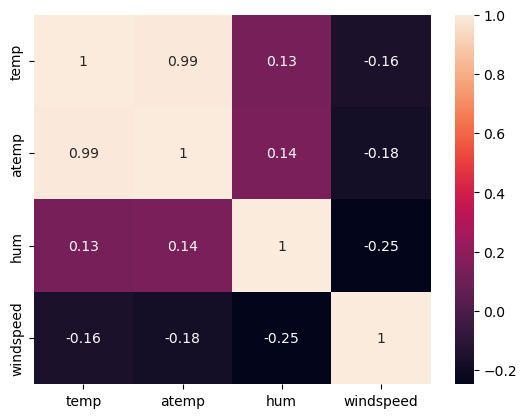

In [11]:
sns.heatmap( df[ X_num_cols ].corr(), annot=True )
plt.show()

The above mentioned 2 points are confirmed. In addition to that, 
- There also seems to be a negative correlation of target variable with the windspeed
- There seems to be no linear correlation between humidity and target variable cnt

We won't be acting on these inferences at the moment. We will do so during model training and feature selection phase

#### Analysis on X Categorical Columns

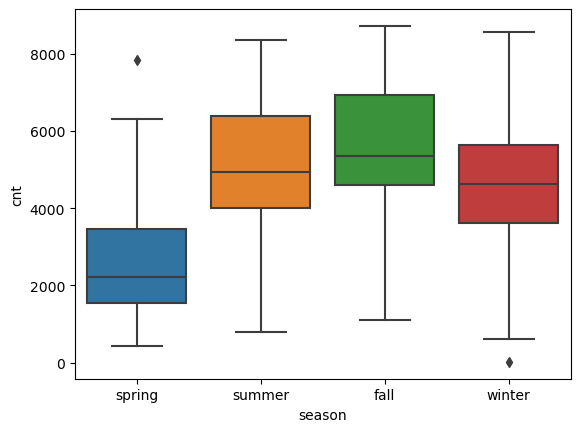

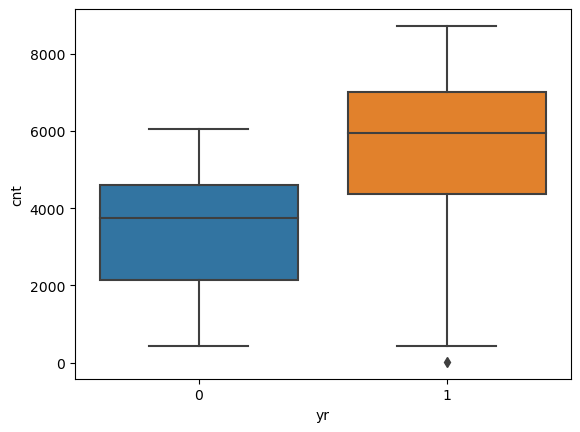

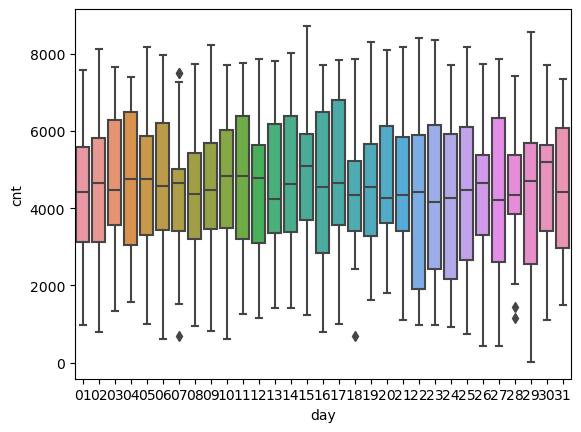

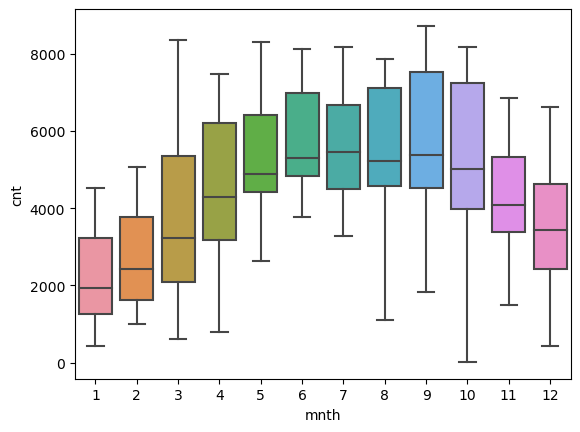

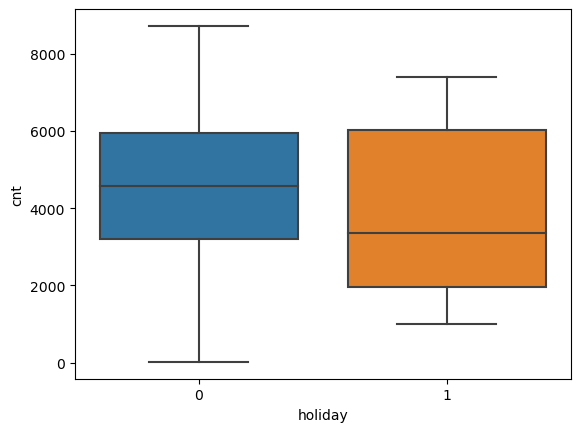

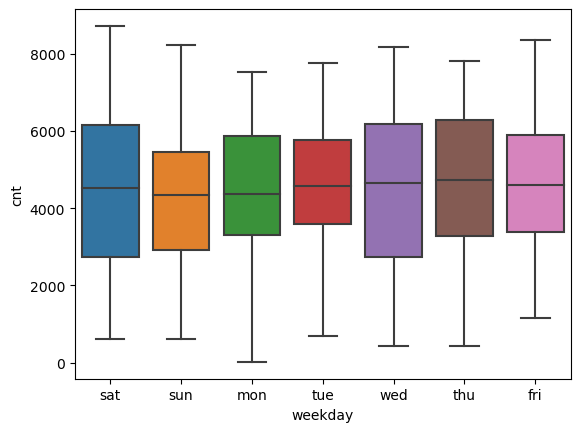

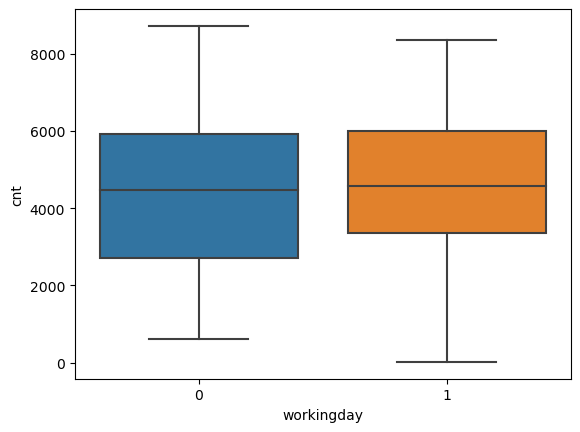

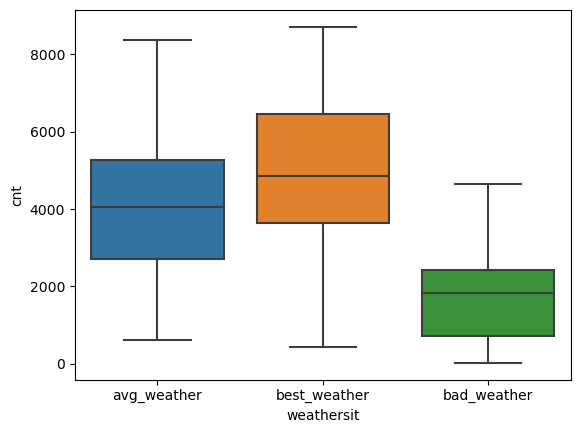

In [12]:
for col in X_cat_cols:
    sns.boxplot(data=df, x=col, y='cnt')
    plt.show()

Following inferences can be made:
- business seems to be worse during the spring and best during the fall. It increases from spring to fall, and decreases from fall to spring.
- More business happenned in 2019 than 2018
- no observable trend between the days and business
- Relationship with months and business mimicks the relation seen with seasons.
- Business seems to low during holidays
- no observable trend bw weekdays and business
- business seems to do a bit better during workdays
- business does better with better weather

# Step 2: Preparing The Data for Modelling

## Encoding

In [13]:
for col in X_cat_cols:
    print(f"Col: {col} | Unique values: {df[ col ].unique()}")

Col: season | Unique values: ['spring' 'summer' 'fall' 'winter']
Col: yr | Unique values: [0 1]
Col: day | Unique values: ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31']
Col: mnth | Unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Col: holiday | Unique values: [0 1]
Col: weekday | Unique values: ['sat' 'sun' 'mon' 'tue' 'wed' 'thu' 'fri']
Col: workingday | Unique values: [0 1]
Col: weathersit | Unique values: ['avg_weather' 'best_weather' 'bad_weather']


So,

In [14]:
X_cat_cols_wth_mult_cats = [ 'season', 'day', 'mnth', 'weekday', 'weathersit' ]

In [15]:
for col in X_cat_cols_wth_mult_cats:
    df[ col ] = df[ col ].astype(str)

In [16]:
df_dummy_vars = pd.get_dummies(df[ X_cat_cols_wth_mult_cats ], drop_first=True, dtype=int)
collist_dummy_vars = list(df_dummy_vars.columns)

df.drop(columns=X_cat_cols_wth_mult_cats, inplace=True)

df = pd.concat([ df, df_dummy_vars ], axis=1)

df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'day_02',
       'day_03', 'day_04', 'day_05', 'day_06', 'day_07', 'day_08', 'day_09',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'weekday_mon',
       'weekday_sat', 'weekday_sun', 'weekday_thu', 'weekday_tue',
       'weekday_wed', 'weathersit_bad_weather', 'weathersit_best_weather'],
      dtype='object')

Now the X categorical columns becomes

In [17]:
X_cat_cols = [ 'yr', 'holiday', 'workingday' ] + collist_dummy_vars
X_cat_cols

['yr',
 'holiday',
 'workingday',
 'season_spring',
 'season_summer',
 'season_winter',
 'day_02',
 'day_03',
 'day_04',
 'day_05',
 'day_06',
 'day_07',
 'day_08',
 'day_09',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 'day_24',
 'day_25',
 'day_26',
 'day_27',
 'day_28',
 'day_29',
 'day_30',
 'day_31',
 'mnth_10',
 'mnth_11',
 'mnth_12',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'weekday_mon',
 'weekday_sat',
 'weekday_sun',
 'weekday_thu',
 'weekday_tue',
 'weekday_wed',
 'weathersit_bad_weather',
 'weathersit_best_weather']

## Splitting into Train and Test Set

In [18]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=100)

print(df_train.shape)
print(df_test.shape)

(584, 60)
(146, 60)


In [19]:
y_train = df_train.pop(y_col)
X_train = df_train
print(y_train.shape)
print(X_train.shape)

(584,)
(584, 59)


In [20]:
y_test = df_test.pop(y_col)
X_test = df_test

print(y_test.shape)
print(X_test.shape)

(146,)
(146, 59)


## Re-scaling the Features

Using Min-Max scaling, so that it will take care of the outliers

In [21]:
scaler = MinMaxScaler()
X_train[ X_num_cols ] = scaler.fit_transform( X_train[ X_num_cols ] )
X_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_8,mnth_9,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad_weather,weathersit_best_weather
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.513699,0.027397,0.667808,0.537414,0.513175,0.649499,0.319463,0.251712,0.246575,0.250000,...,0.090753,0.080479,0.148973,0.150685,0.154110,0.135274,0.133562,0.154110,0.027397,0.630137
std,0.500241,0.163378,0.471403,0.225336,0.211663,0.144219,0.168114,0.434369,0.431387,0.433384,...,0.287504,0.272267,0.356367,0.358048,0.361363,0.342309,0.340472,0.361363,0.163378,0.483181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340113,0.331819,0.535852,0.199177,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.545191,0.530558,0.653714,0.294764,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.736512,0.690521,0.752361,0.410413,1.000000,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Step 3: Building the Model

#### First Draft of the Model

In [22]:
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     60.18
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.87e-195
Time:                        09:21:52   Log-Likelihood:                -4660.8
No. Observations:                 584   AIC:                             9440.
Df Residuals:                     525   BIC:                             9697.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1033.9081    314.161      3.291      0.001     416.740    1651.076
yr                       1991.8581     63.744     31.248      0.000    1866.633    2117.083
holiday                  -233.9194    189.450     -1.235      0.217    -606.093     138.254
workingday                616.9850    103.119      5.983      0.000     414.408     819.562
temp                     3025.5232   1188.225      2.546      0.011     691.264    5359.783
atemp                     856.9757   1171.312      0.732      0.465   -1444.059    3158.010
hum                     -1169.9022    317.755     -3.682      0.000   -1794.129    -545.675
windspeed               -1555.5370    213.881     -7.273      0.000   -1975.705   -1135.369
season_spring            -492.3071    235.903     -2.087      0.037    -955.737     -28.877
season_summer             327.4568    208.593      1.570      0.117     -82.322     737.236
season_winter             965.1928    215.532      4.478      0.000     541.782    1388.603
day_02                    266.3950    221.629      1.202      0.230    -168.994     701.784
day_03                    334.7610    221.399      1.512      0.131    -100.176     769.698
day_04                    297.5469    224.711      1.324      0.186    -143.896     738.990
day_05                    301.8918    224.496      1.345      0.179    -139.129     742.913
day_06                    246.0238    243.275      1.011      0.312    -231.887     723.935
day_07                    113.8321    234.992      0.484      0.628    -347.807     575.471
day_08                    149.9480    233.852      0.641      0.522    -309.453     609.349
day_09                    262.6559    234.231      1.121      0.263    -197.489     722.801
day_10                    449.2031    231.682      1.939      0.053      -5.935     904.341
day_11                    578.8718    227.912      2.540      0.011     131.140    1026.603
day_12                    373.3358    232.648      1.605      0.109     -83.699     830.371
day_13                    260.5547    249.122      1.046      0.296    -228.844     749.953
day_14                    242.2376    231.452      1.047      0.296    -212.449     696.924
day_15                    520.9436    230.560      2.259      0.024      68.009     973.878
day_16                    622.1236    231.949      2.682      0.008     166.462    1077.786
day_17                    663.7386    229.420      2.893      0.004     213.045    1114.432
day_18                    142.1837    238.467      0.596      0.551    -326.283     610.650
day_19                    316.1836    221.349      1.428      0.154    -118.655     751.022
day_20                    558.1181    234.269      2.382      0.018      97.899    1018.337
day_21                    423.3603    226.623  

As is evident, lot of variables can be eliminated using feature selection.

First doing Coarse Tuning using Automated Approach

## Feature Selection

### Feature Selection: Coarse Tuning using RFE

Getting no of RFE high ranking columns vs R2 Score of the model created

In [23]:
list_ncols_vs_r2 = []

for ncols in range(1, len(X_train.columns)+1):
    lr = LinearRegression()
    rfe = RFE(lr, n_features_to_select=ncols)
    rfe = rfe.fit(X_train, y_train)
    
    rfe_y_train_pred = rfe.predict(X_train)
    rfe_train_r2_score = r2_score(y_train, rfe_y_train_pred)
    
    list_ncols_vs_r2 += [ [ncols, rfe_train_r2_score] ]
    
df_ncols_vs_r2 = pd.DataFrame(list_ncols_vs_r2, columns=[ 'no_of_rfe_high_ranking_columns', 'r2_score' ])
df_ncols_vs_r2

,no_of_rfe_high_ranking_columns,r2_score
0,1,0.009767
1,2,0.017811
2,3,0.018543
3,4,0.012619
4,5,0.425899
5,6,0.467204
6,7,0.727322
7,8,0.746239
8,9,0.756912
9,10,0.807675


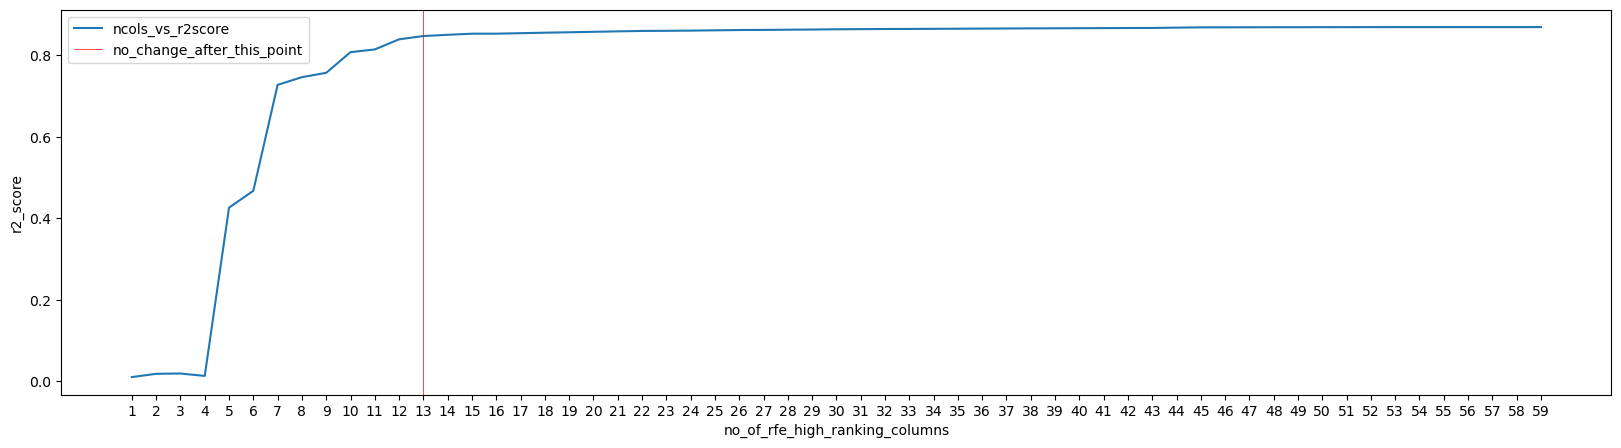

In [24]:
plt.figure(figsize=(20,5))

plt.plot(df_ncols_vs_r2['no_of_rfe_high_ranking_columns'], df_ncols_vs_r2['r2_score'], label='ncols_vs_r2score')
plt.axvline(x=13, color='r', linewidth=0.5, label='no_change_after_this_point')

plt.xlabel('no_of_rfe_high_ranking_columns')
plt.ylabel('r2_score')

plt.xticks(np.arange(min(df_ncols_vs_r2['no_of_rfe_high_ranking_columns']), \
                     max(df_ncols_vs_r2['no_of_rfe_high_ranking_columns'])+1, 1))
plt.legend()
plt.show()

As is evident from the dataframe and graph above, not much difference in R2 score after taking 13 RFE highest ranked variables

So, taking 13 RFE highest ranked columns as finalized result of RFE/coarse tuning

In [25]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=13)
rfe = rfe.fit(X_train, y_train)

X_rfe_filt_cols = list(X_train.columns[ rfe.support_ ])
X_rfe_filt_cols

['yr',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_9',
 'weekday_sat',
 'weekday_sun',
 'weathersit_bad_weather',
 'weathersit_best_weather']

### Feature Selection: Fine Tuning

We take RFE filtered columns as first draft of X columns after feature selection 

In [26]:
X_train_sm = sm.add_constant( X_train[ X_rfe_filt_cols ] )
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     264.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          4.30e-224
Time:                        09:21:57   Log-Likelihood:                -4705.6
No. Observations:                 584   AIC:                             9437.
Df Residuals:                     571   BIC:                             9494.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     887.6761    212.291      4.181      0.000     470.710    1304.642
yr                       1956.5062     64.848     30.170      0.000    1829.136    2083.877
holiday                  -426.4976    165.355     -2.579      0.010    -751.275    -101.720
workingday                558.6390     75.976      7.353      0.000     409.413     707.865
temp                     5083.3729    159.327     31.905      0.000    4770.435    5396.311
hum                     -1410.4121    306.342     -4.604      0.000   -2012.107    -808.718
windspeed               -1594.4361    206.964     -7.704      0.000   -2000.940   -1187.932
season_summer             803.6668     81.337      9.881      0.000     643.911     963.423
season_winter            1266.7332     81.877     15.471      0.000    1105.916    1427.550
mnth_9                    855.8780    124.116      6.896      0.000     612.098    1099.658
weekday_sat               641.0923     93.188      6.880      0.000     458.060     824.125
weekday_sun               114.4423     95.269      1.201      0.230     -72.678     301.563
weathersit_bad_weather  -1694.5323    206.558     -8.204      0.000   -2100.238   -1288.827
weathersit_best_weather   465.2335     84.928      5.478      0.000     298.423     632.044
==============================================================================
Omnibus:                       80.710   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.650
Skew:                          -0.762   Prob(JB):                     4.37e-39
Kurtosis:                       5.222   Cond. No.                     1.15e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
list_col_vs_vif = []
for idx, col in enumerate(X_rfe_filt_cols):
    vif = variance_inflation_factor(X_train[ X_rfe_filt_cols ].values, idx)
    list_col_vs_vif += [ [col, vif] ]
    
df_col_vs_vif = pd.DataFrame(list_col_vs_vif, columns=[ 'column', 'VIF' ])
df_col_vs_vif

,column,VIF
0,yr,1.027571
1,holiday,2.797097
2,workingday,44.939844
3,temp,1.258621
4,hum,1.905951
5,windspeed,1.182106
6,season_summer,1.202171
7,season_winter,1.229491
8,mnth_9,1.115074
9,weekday_sat,10.747605


weekday_sun is insignificant, since it has a p-value greater than 0.05.

So, creating second draft of X columns that does not contain weekday_sun

##### 2nd Column Draft

In [28]:
X_draft_2_filt_cols = [ col for col in X_rfe_filt_cols if col != 'weekday_sun' ]
X_draft_2_filt_cols

['yr',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_9',
 'weekday_sat',
 'weathersit_bad_weather',
 'weathersit_best_weather']

In [29]:
X_train_sm = sm.add_constant( X_train[ X_draft_2_filt_cols ] )
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     264.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          4.30e-224
Time:                        09:21:57   Log-Likelihood:                -4705.6
No. Observations:                 584   AIC:                             9437.
Df Residuals:                     571   BIC:                             9494.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1002.1184    274.198      3.655      0.000     463.559    1540.678
yr                       1956.5062     64.848     30.170      0.000    1829.136    2083.877
holiday                  -540.9399    210.607     -2.568      0.010    -954.600    -127.280
workingday                444.1967     90.766      4.894      0.000     265.921     622.472
temp                     5083.3729    159.327     31.905      0.000    4770.435    5396.311
hum                     -1410.4121    306.342     -4.604      0.000   -2012.107    -808.718
windspeed               -1594.4361    206.964     -7.704      0.000   -2000.940   -1187.932
season_summer             803.6668     81.337      9.881      0.000     643.911     963.423
season_winter            1266.7332     81.877     15.471      0.000    1105.916    1427.550
mnth_9                    855.8780    124.116      6.896      0.000     612.098    1099.658
weekday_sat               526.6500    116.380      4.525      0.000     298.065     755.235
weathersit_bad_weather  -1694.5323    206.558     -8.204      0.000   -2100.238   -1288.827
weathersit_best_weather   465.2335     84.928      5.478      0.000     298.423     632.044
==============================================================================
Omnibus:                       80.710   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.650
Skew:                          -0.762   Prob(JB):                     4.37e-39
Kurtosis:                       5.222   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
list_col_vs_vif = []
for idx, col in enumerate(X_draft_2_filt_cols):
    vif = variance_inflation_factor(X_train[ X_draft_2_filt_cols ].values, idx)
    list_col_vs_vif += [ [col, vif] ]
    
df_col_vs_vif = pd.DataFrame(list_col_vs_vif, columns=[ 'column', 'VIF' ])
df_col_vs_vif

,column,VIF
0,yr,2.031339
1,holiday,1.168161
2,workingday,4.916858
3,temp,8.343529
4,hum,12.045904
5,windspeed,4.076741
6,season_summer,1.594899
7,season_winter,1.638304
8,mnth_9,1.207714
9,weekday_sat,1.873803


All the p-values of variables are below 0.05.<br>
But there are correlations bw the columns in the second draft

Variable hum has the highest VIF, so removing that to creating a 3rd draft of columns

##### 3rd Column Draft

In [31]:
X_draft_3_filt_cols = [ col for col in X_draft_2_filt_cols if col != 'hum' ]
X_draft_3_filt_cols

['yr',
 'holiday',
 'workingday',
 'temp',
 'windspeed',
 'season_summer',
 'season_winter',
 'mnth_9',
 'weekday_sat',
 'weathersit_bad_weather',
 'weathersit_best_weather']

In [32]:
X_train_sm = sm.add_constant( X_train[ X_draft_3_filt_cols ] )
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     276.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          8.07e-221
Time:                        09:21:57   Log-Likelihood:                -4716.3
No. Observations:                 584   AIC:                             9457.
Df Residuals:                     572   BIC:                             9509.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -56.7464    151.915     -0.374      0.709    -355.126     241.633
yr                       1994.8794     65.436     30.486      0.000    1866.355    2123.404
holiday                  -525.8257    214.267     -2.454      0.014    -946.673    -104.979
workingday                460.7435     92.282      4.993      0.000     279.491     641.996
temp                     4910.3309    157.540     31.169      0.000    4600.903    5219.759
windspeed               -1327.3898    202.147     -6.566      0.000   -1724.432    -930.348
season_summer             788.3297     82.691      9.533      0.000     625.914     950.745
season_winter            1197.3806     81.888     14.622      0.000    1036.543    1358.218
mnth_9                    806.7538    125.821      6.412      0.000     559.626    1053.881
weekday_sat               556.1098    118.238      4.703      0.000     323.877     788.343
weathersit_bad_weather  -1860.5583    206.945     -8.991      0.000   -2267.023   -1454.093
weathersit_best_weather   694.5397     69.995      9.923      0.000     557.060     832.019
==============================================================================
Omnibus:                       74.982   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.532
Skew:                          -0.722   Prob(JB):                     2.28e-35
Kurtosis:                       5.114   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
list_col_vs_vif = []
for idx, col in enumerate(X_draft_3_filt_cols):
    vif = variance_inflation_factor(X_train[ X_draft_3_filt_cols ].values, idx)
    list_col_vs_vif += [ [col, vif] ]
    
df_col_vs_vif = pd.DataFrame(list_col_vs_vif, columns=[ 'column', 'VIF' ])
df_col_vs_vif

,column,VIF
0,yr,2.021898
1,holiday,1.132330
2,workingday,4.140351
3,temp,5.417365
4,windspeed,3.707116
5,season_summer,1.576381
6,season_winter,1.406224
7,mnth_9,1.203434
8,weekday_sat,1.716615
9,weathersit_bad_weather,1.107577


Now, temp variable has VIF > 5. 
But going by business judgment, temperature seems more important than whether business happened at the month of September
So, removing mnth_9 variable for 4th draft of columns

##### 4rd Column Draft

In [34]:
X_draft_4_filt_cols = [ col for col in X_draft_3_filt_cols if col != 'mnth_9' ]
X_draft_4_filt_cols

['yr',
 'holiday',
 'workingday',
 'temp',
 'windspeed',
 'season_summer',
 'season_winter',
 'weekday_sat',
 'weathersit_bad_weather',
 'weathersit_best_weather']

In [35]:
X_train_sm = sm.add_constant( X_train[ X_draft_4_filt_cols ] )
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     280.8
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.85e-213
Time:                        09:21:57   Log-Likelihood:                -4736.5
No. Observations:                 584   AIC:                             9495.
Df Residuals:                     573   BIC:                             9543.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -42.0606    157.125     -0.268      0.789    -350.671     266.550
yr                       1988.7979     67.681     29.385      0.000    1855.866    2121.730
holiday                  -475.6132    221.492     -2.147      0.032    -910.649     -40.577
workingday                464.8813     95.455      4.870      0.000     277.397     652.365
temp                     5138.8551    158.736     32.374      0.000    4827.079    5450.631
windspeed               -1406.6311    208.712     -6.740      0.000   -1816.566    -996.697
season_summer             682.0090     83.799      8.139      0.000     517.418     846.600
season_winter            1182.0265     84.670     13.960      0.000    1015.726    1348.327
weekday_sat               572.1973    122.279      4.679      0.000     332.028     812.366
weathersit_bad_weather  -1832.5918    214.019     -8.563      0.000   -2252.948   -1412.235
weathersit_best_weather   660.5677     72.196      9.150      0.000     518.766     802.369
==============================================================================
Omnibus:                       69.935   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.691
Skew:                          -0.647   Prob(JB):                     2.85e-36
Kurtosis:                       5.248   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
list_col_vs_vif = []
for idx, col in enumerate(X_draft_4_filt_cols):
    vif = variance_inflation_factor(X_train[ X_draft_4_filt_cols ].values, idx)
    list_col_vs_vif += [ [col, vif] ]
    
df_col_vs_vif = pd.DataFrame(list_col_vs_vif, columns=[ 'column', 'VIF' ])
df_col_vs_vif

,column,VIF
0,yr,2.021598
1,holiday,1.130445
2,workingday,4.139265
3,temp,4.978551
4,windspeed,3.692768
5,season_summer,1.513292
6,season_winter,1.405297
7,weekday_sat,1.715184
8,weathersit_bad_weather,1.107064
9,weathersit_best_weather,2.693053


Everything (p-values, F-statistics, and VIF) looks good.
So, taking the 4th draft as the final draft of feature selected X columns

##### Finalized Column Draft

In [37]:
X_final_draft_cols = X_draft_4_filt_cols

lr_model_final = lr_model

lr_model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     280.8
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.85e-213
Time:                        09:21:57   Log-Likelihood:                -4736.5
No. Observations:                 584   AIC:                             9495.
Df Residuals:                     573   BIC:                             9543.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -42.0606    157.125     -0.268      0.789    -350.671     266.550
yr                       1988.7979     67.681     29.385      0.000    1855.866    2121.730
holiday                  -475.6132    221.492     -2.147      0.032    -910.649     -40.577
workingday                464.8813     95.455      4.870      0.000     277.397     652.365
temp                     5138.8551    158.736     32.374      0.000    4827.079    5450.631
windspeed               -1406.6311    208.712     -6.740      0.000   -1816.566    -996.697
season_summer             682.0090     83.799      8.139      0.000     517.418     846.600
season_winter            1182.0265     84.670     13.960      0.000    1015.726    1348.327
weekday_sat               572.1973    122.279      4.679      0.000     332.028     812.366
weathersit_bad_weather  -1832.5918    214.019     -8.563      0.000   -2252.948   -1412.235
weathersit_best_weather   660.5677     72.196      9.150      0.000     518.766     802.369
==============================================================================
Omnibus:                       69.935   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.691
Skew:                          -0.647   Prob(JB):                     2.85e-36
Kurtosis:                       5.248   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, the equation looks like <br>
y = -42.0606 +1988.7979\*yr -475.6132\*holiday +464.8813\*workingday +5138.8551\*temp -1406.6311\*windspeed +682.0090\*season_summer +1182.0265\*season_winter +572.1973\*weekday_sat -1832.5918\*weathersit_bad_weather +660.5677\*weathersit_best_weather

# Step 4: Residual Analysis

In [39]:
X_train_final_draft_sm = sm.add_constant(X_train[ X_final_draft_cols ])
y_train_pred = lr_model_final.predict( X_train_final_draft_sm )

res = y_train - y_train_pred

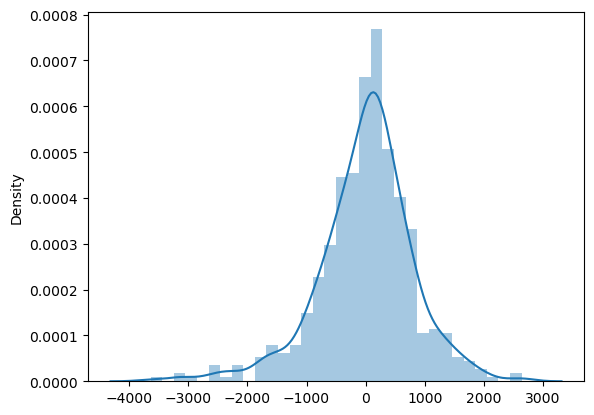

In [40]:
sns.distplot(res)
plt.show()

As is evident from the graph,
- The residuals are centered around 0
- The residuals follow a normal distribution

So, our assumptions are valid

# Step 5: Predictions and Evaluations on the Test Set

## Rescaling

In [43]:
X_test[ X_num_cols ] = scaler.transform(X_test[ X_num_cols ])
X_test[ X_num_cols ].describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_8,mnth_9,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad_weather,weathersit_best_weather
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,1,0,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,1,0,1
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,0,0,0,0,0,1,0,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,1,0,0,0,0,0,0,1,0,1
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,0,0,1,0,0,0,1


## Predict

In [ ]:
X_test_final_draft_sm = sm.add_constant( X_test[ X_final_draft_cols ] )
y_test_pred = lr_model_final.predict( X_test_final_draft_sm )